# 03: Visualizing the Annealing Process

This notebook demonstrates the plotting utilities included in Quasar Solver that help visalizing the annealing process for insights and debugging. We will use the Traveling Salesperson Problem (TSP) explained in example 2 as exemplary problem.

In [20]:
%matplotlib inline
import numpy as np

# Import our solver components and plotting utilities
from quasar_solver import QUBO, Solver
from quasar_solver.utils import ModelConverter
from quasar_solver.plot import plot_energy_convergence, plot_acceptance_probability, plot_temperature_schedule

# pyqubo for building the QUBO model symbolically
from pyqubo import Array, Constraint, Placeholder

print("Setup complete.")

Setup complete.


## Setting up the TSP Problem

We will set up a 12-city TSP problem. For a detailed explanation of the math and constraints, please refer to the `tsp.ipynb` notebook.

In [21]:
# --- 1. Problem Definition ---
cities = ['Berlin', 'Paris', 'Rome', 'Madrid', 'London', 'Vienna', 'Warsaw', 'Stockholm', 'Lisbon', 'Athens', 'Amsterdam', 'Prague']
n_cities = len(cities)

# Distances of the 12 cities to one another
dist_matrix = np.array([
    [0,     877,    1181,   1869,   931,    523,    517,    810,    2312,   1802,   576,    281], 
    [877,   0,      1105,   1052,   343,    1033,   1366,   1543,   1452,   2095,   429,    882], 
    [1181,  1105,   0,      1364,   1433,   764,    1314,   1975,   1863,   1050,   1295,   920], 
    [1869,  1052,   1364,   0,      1263,   1809,   2289,   2593,   502,    2369,   1481,   1772], 
    [931,   343,    1433,   1263,   0,      1235,   1448,   1432,   1584,   2391,   357,    1034], 
    [523,   1033,   764,    1809,   1235,   0,      555,    1241,   2298,   1282,   935,    250], 
    [517,   1366,   1314,   2289,   1448,   555,    0,      810,    2759,   1598,   1093,   517], 
    [810,   1543,   1975,   2593,   1432,   1241,   810,    0,      2759,   1598,   1093,   517], 
    [2312,  1452,   1863,   502,    1584,   2298,   2759,   2988,   0,      2851,   1863,   2243], 
    [1802,  2095,   1050,   2369,   2391,   1282,   1598,   2407,   2851,   0,      2163,   1533], 
    [576,   429,    1295,   1481,   357,    935,    1093,   1125,   1863,   2163,   0,      710], 
    [281,   882,    920,    1772,   1034,   250,    517,    1054,   2243,   1533,   710,    0]
])

# --- 2. Define pyqubo Variables and Hamiltonian ---
x = Array.create('x', (n_cities, n_cities), 'BINARY')
objective_func = 0
for i in range(n_cities):
    for j in range(n_cities):
        for p in range(n_cities):
            objective_func += dist_matrix[i, j] * x[i, p] * x[j, (p + 1) % n_cities]

P = Placeholder('penalty_weight')
constraint_city = sum(Constraint((sum(x[i, p] for p in range(n_cities)) - 1)**2, label=f'city_{i}') for i in range(n_cities))
constraint_step = sum(Constraint((sum(x[i, p] for i in range(n_cities)) - 1)**2, label=f'step_{p}') for p in range(n_cities))
H = objective_func + P * (constraint_city + constraint_step)

# --- 3. Compile and Convert ---
model = H.compile()
feed_dict = {'penalty_weight': np.mean(dist_matrix)}
Q, offset, labels = ModelConverter.from_pyqubo(model, feed_dict)
problem = QUBO(Q)

print(f"TSP Problem setup complete for {n_cities} cities.")

TSP Problem setup complete for 12 cities.


## Running the Solver

To collect the necessary data including intermediate results, as well as the development of energy, acceptances and temperature, we run the solver with `track_history=True`.

In [26]:
solver = Solver(
    qubo=problem,
    initial_temp=50000,
    final_temp=0.1,
    iterations_per_temp=1440,
    schedule_params={'alpha': 0.995},
    track_history=True
)

result = solver.solve()

print(f'\nSolver finished.')
print(f'Lowest energy found: {result.energy}')

Annealing complete. Final energy: -21739.180555545958

Solver finished.
Lowest energy found: -21739.180555545958


## 1. Energy Convergence

This plot shows the current energy (getting lower but noisy) and the best energy found so far (monotonic decreasing).

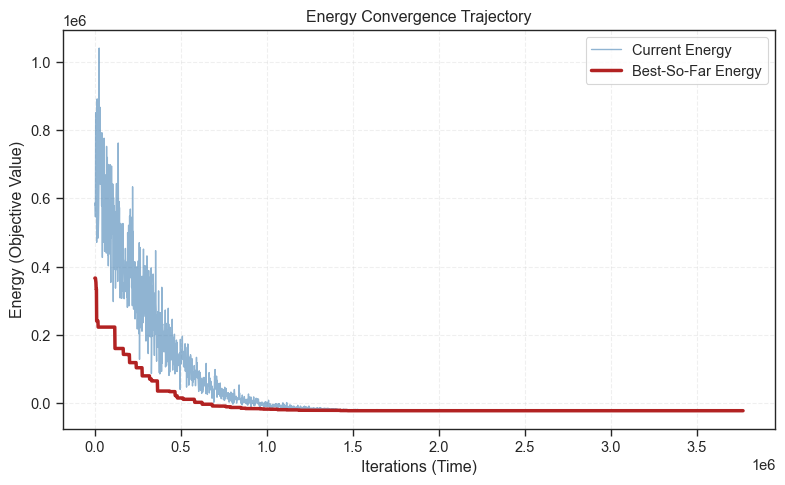

In [27]:
plot_energy_convergence(result.history)

## 2. Acceptance Probability

This plot shows how the probability of accepting worse solutions decreases as the temperature lowers.

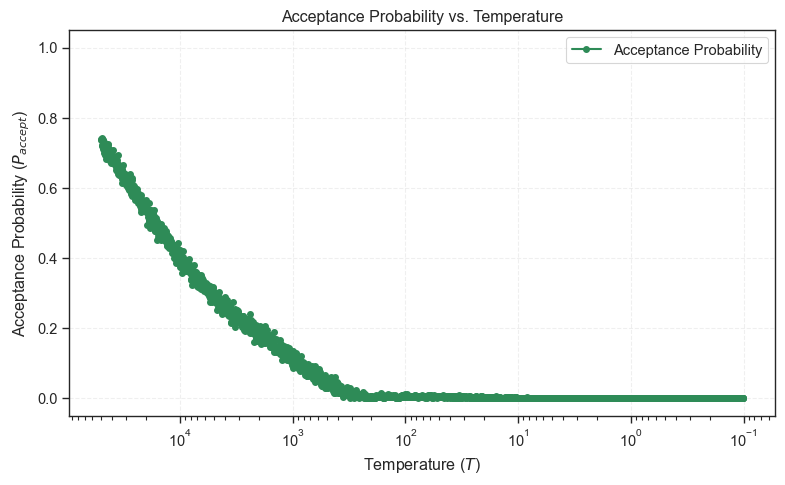

In [28]:
plot_acceptance_probability(result.history)

## 3. Temperature Schedule

Visualizes the cooling schedule over the course of the annealing process.

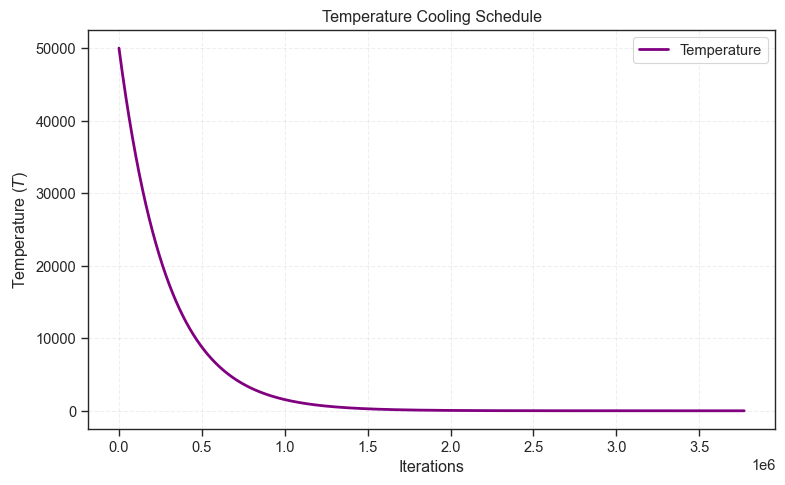

In [29]:
plot_temperature_schedule(result.history)